In [1]:
import os, random, cv2, gc, warnings, math, matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm_notebook
import tensorflow as tf
try:
    from tensorflow.contrib import keras as keras
    print ('load keras from tensorflow package')
except:
    print ('update your tensorflow')
from tensorflow.contrib.keras import models
from tensorflow.contrib.keras import layers

from keras import backend as K
from keras.optimizers import Adam, SGD
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose

warnings.filterwarnings("ignore")
path        = '../input/understanding_cloud_organization/'
img_width   = 128 
img_height  = 128
num_classes = 4
tr          = pd.read_csv(path + 'train.csv')
print(len(tr))
tr.head()

load keras from tensorflow package


Using TensorFlow backend.


22184


,Image_Label,EncodedPixels
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...
2,0011165.jpg_Gravel,NaN
3,0011165.jpg_Sugar,NaN
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...


In [2]:
def rle2mask(rle, imgshape):
    width = imgshape[0]
    height= imgshape[1]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return np.flipud( np.rot90( mask.reshape(height, width), k=1 ) )

def mask2rle(img):
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

img_names_all = tr['Image_Label'].apply(lambda x: x.split('_')[0]).unique()
len(img_names_all)

5546

In [3]:
new_ep = True
def keras_generator(batch_size):  
    global new_ep
    while True:   
        
        x_batch = []
        y_batch = []        
        for _ in range(batch_size):                         
            if new_ep == True:
                img_names =  img_names_all
                new_ep = False
            
            fn = img_names[random.randrange(0, len(img_names))]                                   

            img = cv2.imread(path + 'train_images/'+ fn)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)                       
            masks = []
            for rle in tr[tr['Image_Label'].apply(lambda x: x.split('_')[0]) == fn]['EncodedPixels']:                
                if pd.isnull(rle):
                    mask = np.zeros((img_width, img_height))
                else:
                    mask = rle2mask(rle, img.shape)
                    mask = cv2.resize(mask, (img_width, img_height))
                masks.append(mask)                                        
            img = cv2.resize(img, (img_width, img_height))            
            x_batch += [img]
            y_batch += [masks] 

            img_names = img_names[img_names != fn]   
 
        x_batch = np.array(x_batch)
        y_batch = np.transpose(np.array(y_batch), (0, 2, 3, 1))        

        yield x_batch, y_batch

In [4]:
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


def get_model():
    inputs = Input((img_width,img_height, 3))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(num_classes, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])
#     sgd = SGD(lr=0.01, decay=1e-6, momentum=0.3, nesterov=False)
#     model.compile(optimizer=Adam(lr=0.001), loss=dice_coef_loss, metrics=[dice_coef])
    model.compile(optimizer='sgd', loss='binary_crossentropy',metrics=['accuracy'])

    return model

model = get_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 32)   0           conv2d_2[0][0]                   
____________________________________________________________________________________________

In [5]:
class EpochBegin(keras.callbacks.Callback):
    def on_epoch_begin (self, epoch, logs={}):
        global new_ep
        new_ep = True
Epoch_Begin_Clb = EpochBegin()

reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(
                              monitor='loss',
                              mode='auto',
                              factor=0.666,
                              patience=1,
                              min_lr=0,
                              cooldown=0,
                              verbose=1)


In [6]:
%%time
batch_size=16
model.fit_generator(keras_generator(batch_size),
              steps_per_epoch=200,                    
              epochs=2,
              callbacks=[Epoch_Begin_Clb])

Epoch 1/2
200/200 [==============================] - 310s 2s/step - loss: 0.5085 - accuracy: 0.8327
Epoch 2/2
200/200 [==============================] - 305s 2s/step - loss: 0.4513 - accuracy: 0.8483
CPU times: user 10min 18s, sys: 17.5 s, total: 10min 35s
Wall time: 10min 19s


In [7]:
gc.collect()

26

In [8]:
%%time
test_img = []
testfiles=os.listdir(path + 'test_images/')
for fn in tqdm_notebook(testfiles):     
        img = cv2.imread( path + 'test_images/'+fn )
        img = cv2.resize(img,(img_width, img_height))       
        test_img.append(img)
len(test_img)


CPU times: user 2min 21s, sys: 3.47 s, total: 2min 25s
Wall time: 2min 48s


3698

In [9]:
%%time
predict = model.predict(np.asarray(test_img))

CPU times: user 2.24 s, sys: 3.32 s, total: 5.57 s
Wall time: 5.24 s


In [10]:
%%time
pred_rle = []
for img in predict:      
    img = cv2.resize(img, (525, 350))
    tmp = np.copy(img)
    tmp[tmp<np.mean(img)] = 0
    tmp[tmp>0] = 1
    for i in range(tmp.shape[-1]):
        pred_rle.append(mask2rle(tmp[:,:,i]))
len(pred_rle)

CPU times: user 2min 51s, sys: 724 ms, total: 2min 52s
Wall time: 2min 48s


14792

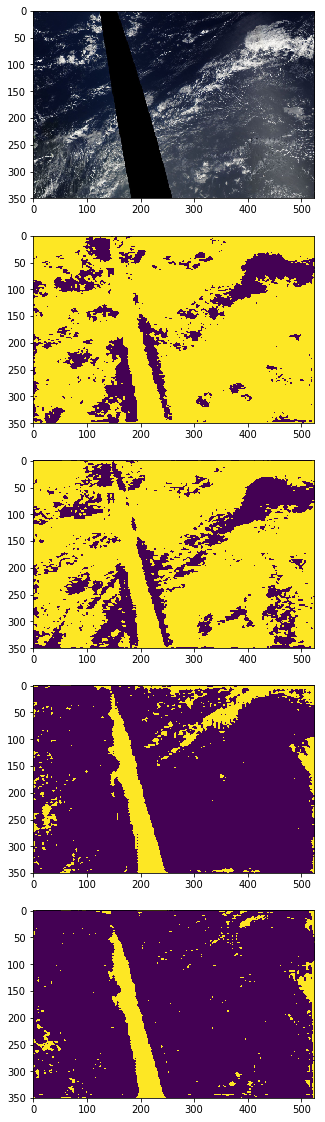

In [11]:
fig, axs = plt.subplots(5, figsize=(20, 20))
axs[0].imshow(cv2.resize(plt.imread(path + 'test_images/' + testfiles[0]),(525, 350)))
for i in range(4):
    axs[i+1].imshow(rle2mask(pred_rle[i], img.shape))

In [12]:
sub = pd.read_csv( path + 'sample_submission.csv', converters={'EncodedPixels': lambda e: ' '} )
sub['EncodedPixels'] = pred_rle
sub.head()

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,1 42 44 40 86 2 108 3 119 9 132 3 141 43 195 4...
1,002f507.jpg_Flower,1 42 44 43 89 2 109 4 119 27 154 41 215 7 227 ...
2,002f507.jpg_Gravel,1 2 31 2 37 3 44 17 89 1 122 8 132 3 151 10 17...
3,002f507.jpg_Sugar,40 7 51 4 152 2 240 7 256 1 267 1 289 5 335 1 ...
4,0035ae9.jpg_Fish,1 3 7 4 18 2 47 32 80 4 89 6 96 16 115 7 126 3...


In [13]:
sub.to_csv('submission.csv', index=False)